# Train ML methods

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls

gdrive	sample_data


In [5]:
%cd gdrive/MyDrive/Colab\ Notebooks/EEG

/content/gdrive/MyDrive/Colab Notebooks/EEG


In [6]:
def find_filenames(ls):
  output = []
  for file in ls:
    output.append(os.path.basename(file))
  return output

In [7]:
## import our classifiers
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## The VotingClassifier
from sklearn.ensemble import VotingClassifier

## import accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## split data
from sklearn.model_selection import train_test_split

## validation and model selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [8]:
def print_grid_search_metrics(gs):
  # gs: grid search result.
  print('Best score:', gs.best_score_)
  print('Best parameters set:')
  best_parameters = gs.best_params_
  for param_name in sorted(best_parameters.keys()):
    print(param_name + ':'+str(best_parameters[param_name]))

In [9]:
url = 'https://raw.githubusercontent.com/jgeller112/ERDOS_EEG_Project/main/Featuer_Folder/jos_jason_derk.csv'
df_full = pd.read_csv(url, error_bad_lines=False)
df_full

,subject,alcoholic,CP5_F2_match,CP5_F2_nomatch,CP5_F2_obj,CP2_FT8_match,CP2_FT8_nomatch,CP2_FT8_obj,P3_PO2_match,P3_PO2_nomatch,P3_PO2_obj,P4_FT8_match,P4_FT8_nomatch,P4_FT8_obj,AF7_FT8_match,AF7_FT8_nomatch,AF7_FT8_obj,AF7_C1_match,AF7_C1_nomatch,AF7_C1_obj,F5_FC4_match,F5_FC4_nomatch,F5_FC4_obj,F5_CPZ_match,F5_CPZ_nomatch,F5_CPZ_obj,F5_nd_match,F5_nd_nomatch,F5_nd_obj,FC4_C1_match,FC4_C1_nomatch,FC4_C1_obj,F7_C1_match,F7_C1_nomatch,F7_C1_obj,FZ_nd_match,FZ_nd_nomatch,FZ_nd_obj,F3_PZ_match,F3_PZ_nomatch,...,S2 nomatch_27,S2 nomatch_28,S2 nomatch_29,S2 nomatch_30,S2 nomatch_31,S2 nomatch_32,S2 nomatch_33,S2 nomatch_34,S2 nomatch_35,S2 nomatch_36,S2 nomatch_37,S2 nomatch_38,S2 nomatch_39,S2 nomatch_40,S2 nomatch_41,S2 nomatch_42,S2 nomatch_43,S2 nomatch_44,S2 nomatch_45,S2 nomatch_46,S2 nomatch_47,S2 nomatch_48,S2 nomatch_49,S2 nomatch_50,S2 nomatch_51,S2 nomatch_52,S2 nomatch_53,S2 nomatch_54,S2 nomatch_55,S2 nomatch_56,S2 nomatch_57,S2 nomatch_58,S2 nomatch_59,S2 nomatch_60,S2 nomatch_61,S2 nomatch_62,S2 nomatch_63,S2 nomatch_64,S2 nomatch_65,S2 nomatch_66
0,co2a0000364,True,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,0.029983,0.391106,-0.308248,-0.086077,-0.348527,-0.168177,0.054573,0.011416,-0.217446,-0.390030,-0.434960,0.370786,0.026289,0.333988,-0.416310,-0.154351,-0.326373,-0.354692,-0.269821,-0.410471,0.285090,0.128058,-0.051710,-0.016800,-0.368476,-0.217611,-0.306759,-0.043362,-0.466811,-0.265465,-0.297740,...,0.330925,-2.871611,-1.991815,-0.177882,1.740226,-1.415681,1.100915,-2.125324,-0.553760,1.284077,-1.495113,-1.022517,-1.169565,-3.901884,-2.912574,1.735796,-8.918536,-8.801575,-8.774446,-4.851970,-3.974949,-5.772581,-4.653402,-6.904406,-6.678557,-8.966721,-9.089526,-6.706207,-6.400868,-9.167917,-9.056884,-6.236302,-3.325961,-5.850788,-4.359075,-7.297059,-6.658570,-4.840563,-5.280862,-1.515978
1,co2a0000365,True,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,0.749709,0.601833,-0.546903,-0.248024,-0.618077,0.447616,0.435534,0.487478,-0.351182,-0.543823,-0.357850,0.341579,0.233268,0.633680,-0.410623,-0.609028,-0.362812,-0.559236,-0.373830,-0.605347,-0.134713,-0.014201,0.001111,-0.378380,-0.420487,0.042893,-0.243619,-0.328721,-0.420628,-0.235227,-0.402396,...,-1.789719,-7.481258,-5.491188,-1.493375,-0.472253,-1.517060,0.660732,-2.217498,-0.915937,-0.754970,-5.952021,-3.789421,-3.312081,-4.765420,-2.640406,-2.036506,-5.168321,-5.649331,-5.537859,-0.356928,-4.253177,-1.248507,-1.699031,-3.009281,-2.618047,-3.908971,-4.215917,-2.499295,-7.511376,-4.643766,-5.339362,-2.167782,0.041340,-5.048214,-3.231357,-4.539841,-4.849819,-5.032939,-5.764136,-5.893749
2,co2a0000368,True,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,0.736933,0.870077,-0.472805,-0.359966,-0.310612,0.638932,0.478172,0.526605,-0.646327,-0.646982,-0.697897,-0.050020,0.137914,0.260522,-0.593201,-0.439165,-0.417511,-0.485304,-0.415543,-0.452748,-0.074093,-0.153492,-0.328818,-0.367096,-0.437984,-0.385186,-0.440993,-0.392447,-0.500812,0.120786,-0.178748,...,-2.839838,-4.834615,-4.496521,-3.002613,-2.574866,-2.069979,-2.703131,-4.284663,-3.354119,-2.193297,-4.102847,-4.328241,-3.835821,-4.676146,-3.717970,-2.996042,-6.687219,-7.336703,-6.543707,-3.362387,-3.405276,-3.947446,-4.123737,-4.262129,-5.609556,-6.142757,-6.523558,-4.805482,-5.858526,-7.217434,-8.047818,-5.752106,-3.037136,-5.238939,-4.868118,-5.440853,-4.729788,-7.427804,-6.740293,-3.735114
3,co2a0000369,True,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,0.652720,0.804274,-0.691791,-0.613592,-0.632684,0.991764,0.981736,0.991996,-0.752711,-0.713433,-0.681256,0.338702,0.330820,0.596910,-0.692686,-0.672552,-0.661477,-0.797908,-0.710085,-0.733342,-0.214897,-0.465308,-0.392701,-0.552068,-0.429733,-0.658207,-0.784813,-0.690836,-0.727417,-0.408837,-0.398870,...,-3.652365,-6.499808,-6.044880,-2.054526,-1.088403,-3.336413,-1.241196,-4.037562,-2.915533,-1.690245,-6.575610,-5.781837,-5.354235,-6.028842,-5.473263,-3.291034,-3.091190,-

In [ ]:
#df_full = pd.read_csv("full_corr_121.csv",index_col=None)

#df_full = pd.read_csv('full_sub_corr.csv')
#df_full.rename(columns={'0':'subject','1':'alcoholic','2':'condition'}, inplace=True)
#df_full = df_full.drop(columns=['Unnamed: 0'])
df_full

,subject,alcoholic,CZ_P8_match,CZ_P8_nomatch,CZ_P8_obj,C4_C4_match,C4_C4_nomatch,C4_C4_obj,C4_AFZ_match,C4_AFZ_nomatch,C4_AFZ_obj,CP5_AF7_match,CP5_AF7_nomatch,CP5_AF7_obj,P4_CP5_match,P4_CP5_nomatch,P4_CP5_obj,P4_AF8_match,P4_AF8_nomatch,P4_AF8_obj,PZ_T8_match,PZ_T8_nomatch,PZ_T8_obj,PZ_F6_match,PZ_F6_nomatch,PZ_F6_obj,PZ_FT7_match,PZ_FT7_nomatch,PZ_FT7_obj,P7_P4_match,P7_P4_nomatch,P7_P4_obj,F7_C5_match,F7_C5_nomatch,F7_C5_obj,FZ_P7_match,FZ_P7_nomatch,FZ_P7_obj,F4_AF8_match,F4_AF8_nomatch,F4_AF8_obj,F4_F5_match,F4_F5_nomatch,F4_F5_obj,F4_FPZ_match,F4_FPZ_nomatch,F4_FPZ_obj,T8_FP1_match,T8_FP1_nomatch,T8_FP1_obj,T8_TP7_match,T8_TP7_nomatch,T8_TP7_obj
0,co2a0000364,True,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,0.029983,0.391106,-0.308248,-0.086077,-0.348527,-0.168177,0.054573,0.011416,-0.217446,-0.390030,-0.434960,0.370786,0.026289,0.333988,-0.416310,-0.154351,-0.326373,-0.354692,-0.269821,-0.410471,0.285090,0.128058,-0.051710,-0.016800,-0.368476,-0.217611,-0.306759,-0.043362,-0.466811,-0.265465,-0.297740,-0.269776,-0.383574,0.102622,0.099764,-0.485798,-0.284645,-0.102781,0.434052,0.139421,0.295287,0.511846,0.440057,0.453594
1,co2a0000365,True,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,0.749709,0.601833,-0.546903,-0.248024,-0.618077,0.447616,0.435534,0.487478,-0.351182,-0.543823,-0.357850,0.341579,0.233268,0.633680,-0.410623,-0.609028,-0.362812,-0.559236,-0.373830,-0.605347,-0.134713,-0.014201,0.001111,-0.378380,-0.420487,0.042893,-0.243619,-0.328721,-0.420628,-0.235227,-0.402396,-0.371312,0.002112,-0.036946,-0.025126,-0.218649,-0.267971,-0.059935,0.283078,-0.064891,0.147295,0.758492,0.143721,0.474611
2,co2a0000368,True,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,0.736933,0.870077,-0.472805,-0.359966,-0.310612,0.638932,0.478172,0.526605,-0.646327,-0.646982,-0.697897,-0.050020,0.137914,0.260522,-0.593201,-0.439165,-0.417511,-0.485304,-0.415543,-0.452748,-0.074093,-0.153492,-0.328818,-0.367096,-0.437984,-0.385186,-0.440993,-0.392447,-0.500812,0.120786,-0.178748,-0.415712,-0.004656,0.009312,-0.284045,-0.183094,-0.393336,-0.435021,0.367548,0.058413,-0.217391,0.506784,0.429274,-0.068739
3,co2a0000369,True,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,0.652720,0.804274,-0.691791,-0.613592,-0.632684,0.991764,0.981736,0.991996,-0.752711,-0.713433,-0.681256,0.338702,0.330820,0.596910,-0.692686,-0.672552,-0.661477,-0.797908,-0.710085,-0.733342,-0.214897,-0.465308,-0.392701,-0.552068,-0.429733,-0.658207,-0.784813,-0.690836,-0.727417,-0.408837,-0.398870,-0.648285,-0.296230,-0.381960,-0.419266,-0.261394,-0.587051,-0.608760,0.451166,-0.083993,-0.160522,0.643504,0.382490,0.172355
4,co2a0000370,True,0.719606,0.812764,-0.049233,-0.472912,-0.489829,-0.607273,0.632839,0.222899,0.658522,-0.400183,-0.398420,-0.553114,0.382971,0.265219,0.381827,-0.435091,-0.282406,-0.573122,0.489790,0.419692,0.451528,-0.355900,-0.282277,-0.536070,-0.363980,-0.425034,-0.558759,0.181720,0.068516,-0.125604,-0.587345,-0.433564,-0.617821,-0.079915,-0.334632,-0.544414,-0.586789,-0.646367,-0.744045,-0.243755,-0.010313,-0.799761,-0.368631,-0.138330,-0.788923,-0.108541,-0.045552,0.343789,0.202136,0.360705,-0.124192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,co3a0000458,True,0.831934,0.862534,0.882192,-0.436328,-0.439382,-0.621502,0.657140,0.559631,-0.012934,-0.243012,-0.272869,-0.122420,0.630815,0.715212,0.518137,-0.763384,-0.630752,-0.666249,0.159739,0.384856,0.603025,-0.291926,-0.295492,-0.177567,-0.403023,-0.375379,-0.547994,-0.395334,-0.448664,-0.215345,-0.637934,-0.575662,-0.658815,-0.603124,-0.353360,-0.432877,-0.317368,-0.010096,-0.690177,0.120688,0.275148,-0.067739,-0.121979,0.018773,-0.412427,-0.035299,0.293069,-0.024336,0.611039,0.713741,0.278293
117,co3a0000459,True,0.378329,0.804246,0.700227,-0.559

In [10]:
df_full = df_full.drop_duplicates()
print(len(df_full.subject))
print(len(df_full.subject.unique()))

121
121


In [11]:
df_copy = df_full.copy()
df_copy

,subject,alcoholic,CP5_F2_match,CP5_F2_nomatch,CP5_F2_obj,CP2_FT8_match,CP2_FT8_nomatch,CP2_FT8_obj,P3_PO2_match,P3_PO2_nomatch,P3_PO2_obj,P4_FT8_match,P4_FT8_nomatch,P4_FT8_obj,AF7_FT8_match,AF7_FT8_nomatch,AF7_FT8_obj,AF7_C1_match,AF7_C1_nomatch,AF7_C1_obj,F5_FC4_match,F5_FC4_nomatch,F5_FC4_obj,F5_CPZ_match,F5_CPZ_nomatch,F5_CPZ_obj,F5_nd_match,F5_nd_nomatch,F5_nd_obj,FC4_C1_match,FC4_C1_nomatch,FC4_C1_obj,F7_C1_match,F7_C1_nomatch,F7_C1_obj,FZ_nd_match,FZ_nd_nomatch,FZ_nd_obj,F3_PZ_match,F3_PZ_nomatch,...,S2 nomatch_27,S2 nomatch_28,S2 nomatch_29,S2 nomatch_30,S2 nomatch_31,S2 nomatch_32,S2 nomatch_33,S2 nomatch_34,S2 nomatch_35,S2 nomatch_36,S2 nomatch_37,S2 nomatch_38,S2 nomatch_39,S2 nomatch_40,S2 nomatch_41,S2 nomatch_42,S2 nomatch_43,S2 nomatch_44,S2 nomatch_45,S2 nomatch_46,S2 nomatch_47,S2 nomatch_48,S2 nomatch_49,S2 nomatch_50,S2 nomatch_51,S2 nomatch_52,S2 nomatch_53,S2 nomatch_54,S2 nomatch_55,S2 nomatch_56,S2 nomatch_57,S2 nomatch_58,S2 nomatch_59,S2 nomatch_60,S2 nomatch_61,S2 nomatch_62,S2 nomatch_63,S2 nomatch_64,S2 nomatch_65,S2 nomatch_66
0,co2a0000364,True,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,0.029983,0.391106,-0.308248,-0.086077,-0.348527,-0.168177,0.054573,0.011416,-0.217446,-0.390030,-0.434960,0.370786,0.026289,0.333988,-0.416310,-0.154351,-0.326373,-0.354692,-0.269821,-0.410471,0.285090,0.128058,-0.051710,-0.016800,-0.368476,-0.217611,-0.306759,-0.043362,-0.466811,-0.265465,-0.297740,...,0.330925,-2.871611,-1.991815,-0.177882,1.740226,-1.415681,1.100915,-2.125324,-0.553760,1.284077,-1.495113,-1.022517,-1.169565,-3.901884,-2.912574,1.735796,-8.918536,-8.801575,-8.774446,-4.851970,-3.974949,-5.772581,-4.653402,-6.904406,-6.678557,-8.966721,-9.089526,-6.706207,-6.400868,-9.167917,-9.056884,-6.236302,-3.325961,-5.850788,-4.359075,-7.297059,-6.658570,-4.840563,-5.280862,-1.515978
1,co2a0000365,True,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,0.749709,0.601833,-0.546903,-0.248024,-0.618077,0.447616,0.435534,0.487478,-0.351182,-0.543823,-0.357850,0.341579,0.233268,0.633680,-0.410623,-0.609028,-0.362812,-0.559236,-0.373830,-0.605347,-0.134713,-0.014201,0.001111,-0.378380,-0.420487,0.042893,-0.243619,-0.328721,-0.420628,-0.235227,-0.402396,...,-1.789719,-7.481258,-5.491188,-1.493375,-0.472253,-1.517060,0.660732,-2.217498,-0.915937,-0.754970,-5.952021,-3.789421,-3.312081,-4.765420,-2.640406,-2.036506,-5.168321,-5.649331,-5.537859,-0.356928,-4.253177,-1.248507,-1.699031,-3.009281,-2.618047,-3.908971,-4.215917,-2.499295,-7.511376,-4.643766,-5.339362,-2.167782,0.041340,-5.048214,-3.231357,-4.539841,-4.849819,-5.032939,-5.764136,-5.893749
2,co2a0000368,True,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,0.736933,0.870077,-0.472805,-0.359966,-0.310612,0.638932,0.478172,0.526605,-0.646327,-0.646982,-0.697897,-0.050020,0.137914,0.260522,-0.593201,-0.439165,-0.417511,-0.485304,-0.415543,-0.452748,-0.074093,-0.153492,-0.328818,-0.367096,-0.437984,-0.385186,-0.440993,-0.392447,-0.500812,0.120786,-0.178748,...,-2.839838,-4.834615,-4.496521,-3.002613,-2.574866,-2.069979,-2.703131,-4.284663,-3.354119,-2.193297,-4.102847,-4.328241,-3.835821,-4.676146,-3.717970,-2.996042,-6.687219,-7.336703,-6.543707,-3.362387,-3.405276,-3.947446,-4.123737,-4.262129,-5.609556,-6.142757,-6.523558,-4.805482,-5.858526,-7.217434,-8.047818,-5.752106,-3.037136,-5.238939,-4.868118,-5.440853,-4.729788,-7.427804,-6.740293,-3.735114
3,co2a0000369,True,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,0.652720,0.804274,-0.691791,-0.613592,-0.632684,0.991764,0.981736,0.991996,-0.752711,-0.713433,-0.681256,0.338702,0.330820,0.596910,-0.692686,-0.672552,-0.661477,-0.797908,-0.710085,-0.733342,-0.214897,-0.465308,-0.392701,-0.552068,-0.429733,-0.658207,-0.784813,-0.690836,-0.727417,-0.408837,-0.398870,...,-3.652365,-6.499808,-6.044880,-2.054526,-1.088403,-3.336413,-1.241196,-4.037562,-2.915533,-1.690245,-6.575610,-5.781837,-5.354235,-6.028842,-5.473263,-3.291034,-3.091190,-

In [12]:
y = df_copy.alcoholic
X = df_copy.drop('alcoholic', axis = 1)


In [13]:
X

,subject,CP5_F2_match,CP5_F2_nomatch,CP5_F2_obj,CP2_FT8_match,CP2_FT8_nomatch,CP2_FT8_obj,P3_PO2_match,P3_PO2_nomatch,P3_PO2_obj,P4_FT8_match,P4_FT8_nomatch,P4_FT8_obj,AF7_FT8_match,AF7_FT8_nomatch,AF7_FT8_obj,AF7_C1_match,AF7_C1_nomatch,AF7_C1_obj,F5_FC4_match,F5_FC4_nomatch,F5_FC4_obj,F5_CPZ_match,F5_CPZ_nomatch,F5_CPZ_obj,F5_nd_match,F5_nd_nomatch,F5_nd_obj,FC4_C1_match,FC4_C1_nomatch,FC4_C1_obj,F7_C1_match,F7_C1_nomatch,F7_C1_obj,FZ_nd_match,FZ_nd_nomatch,FZ_nd_obj,F3_PZ_match,F3_PZ_nomatch,F3_PZ_obj,...,S2 nomatch_27,S2 nomatch_28,S2 nomatch_29,S2 nomatch_30,S2 nomatch_31,S2 nomatch_32,S2 nomatch_33,S2 nomatch_34,S2 nomatch_35,S2 nomatch_36,S2 nomatch_37,S2 nomatch_38,S2 nomatch_39,S2 nomatch_40,S2 nomatch_41,S2 nomatch_42,S2 nomatch_43,S2 nomatch_44,S2 nomatch_45,S2 nomatch_46,S2 nomatch_47,S2 nomatch_48,S2 nomatch_49,S2 nomatch_50,S2 nomatch_51,S2 nomatch_52,S2 nomatch_53,S2 nomatch_54,S2 nomatch_55,S2 nomatch_56,S2 nomatch_57,S2 nomatch_58,S2 nomatch_59,S2 nomatch_60,S2 nomatch_61,S2 nomatch_62,S2 nomatch_63,S2 nomatch_64,S2 nomatch_65,S2 nomatch_66
0,co2a0000364,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,0.029983,0.391106,-0.308248,-0.086077,-0.348527,-0.168177,0.054573,0.011416,-0.217446,-0.390030,-0.434960,0.370786,0.026289,0.333988,-0.416310,-0.154351,-0.326373,-0.354692,-0.269821,-0.410471,0.285090,0.128058,-0.051710,-0.016800,-0.368476,-0.217611,-0.306759,-0.043362,-0.466811,-0.265465,-0.297740,-0.269776,...,0.330925,-2.871611,-1.991815,-0.177882,1.740226,-1.415681,1.100915,-2.125324,-0.553760,1.284077,-1.495113,-1.022517,-1.169565,-3.901884,-2.912574,1.735796,-8.918536,-8.801575,-8.774446,-4.851970,-3.974949,-5.772581,-4.653402,-6.904406,-6.678557,-8.966721,-9.089526,-6.706207,-6.400868,-9.167917,-9.056884,-6.236302,-3.325961,-5.850788,-4.359075,-7.297059,-6.658570,-4.840563,-5.280862,-1.515978
1,co2a0000365,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,0.749709,0.601833,-0.546903,-0.248024,-0.618077,0.447616,0.435534,0.487478,-0.351182,-0.543823,-0.357850,0.341579,0.233268,0.633680,-0.410623,-0.609028,-0.362812,-0.559236,-0.373830,-0.605347,-0.134713,-0.014201,0.001111,-0.378380,-0.420487,0.042893,-0.243619,-0.328721,-0.420628,-0.235227,-0.402396,-0.371312,...,-1.789719,-7.481258,-5.491188,-1.493375,-0.472253,-1.517060,0.660732,-2.217498,-0.915937,-0.754970,-5.952021,-3.789421,-3.312081,-4.765420,-2.640406,-2.036506,-5.168321,-5.649331,-5.537859,-0.356928,-4.253177,-1.248507,-1.699031,-3.009281,-2.618047,-3.908971,-4.215917,-2.499295,-7.511376,-4.643766,-5.339362,-2.167782,0.041340,-5.048214,-3.231357,-4.539841,-4.849819,-5.032939,-5.764136,-5.893749
2,co2a0000368,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,0.736933,0.870077,-0.472805,-0.359966,-0.310612,0.638932,0.478172,0.526605,-0.646327,-0.646982,-0.697897,-0.050020,0.137914,0.260522,-0.593201,-0.439165,-0.417511,-0.485304,-0.415543,-0.452748,-0.074093,-0.153492,-0.328818,-0.367096,-0.437984,-0.385186,-0.440993,-0.392447,-0.500812,0.120786,-0.178748,-0.415712,...,-2.839838,-4.834615,-4.496521,-3.002613,-2.574866,-2.069979,-2.703131,-4.284663,-3.354119,-2.193297,-4.102847,-4.328241,-3.835821,-4.676146,-3.717970,-2.996042,-6.687219,-7.336703,-6.543707,-3.362387,-3.405276,-3.947446,-4.123737,-4.262129,-5.609556,-6.142757,-6.523558,-4.805482,-5.858526,-7.217434,-8.047818,-5.752106,-3.037136,-5.238939,-4.868118,-5.440853,-4.729788,-7.427804,-6.740293,-3.735114
3,co2a0000369,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,0.652720,0.804274,-0.691791,-0.613592,-0.632684,0.991764,0.981736,0.991996,-0.752711,-0.713433,-0.681256,0.338702,0.330820,0.596910,-0.692686,-0.672552,-0.661477,-0.797908,-0.710085,-0.733342,-0.214897,-0.465308,-0.392701,-0.552068,-0.429733,-0.658207,-0.784813,-0.690836,-0.727417,-0.408837,-0.398870,-0.648285,...,-3.652365,-6.499808,-6.044880,-2.054526,-1.088403,-3.336413,-1.241196,-4.037562,-2.915533,-1.690245,-6.575610,-5.781837,-5.354235,-6.028842,-5.473263,-

In [14]:
X = X.drop('subject', axis = 1)
# If there is a categoric data
X = pd.get_dummies(X)
X

,CP5_F2_match,CP5_F2_nomatch,CP5_F2_obj,CP2_FT8_match,CP2_FT8_nomatch,CP2_FT8_obj,P3_PO2_match,P3_PO2_nomatch,P3_PO2_obj,P4_FT8_match,P4_FT8_nomatch,P4_FT8_obj,AF7_FT8_match,AF7_FT8_nomatch,AF7_FT8_obj,AF7_C1_match,AF7_C1_nomatch,AF7_C1_obj,F5_FC4_match,F5_FC4_nomatch,F5_FC4_obj,F5_CPZ_match,F5_CPZ_nomatch,F5_CPZ_obj,F5_nd_match,F5_nd_nomatch,F5_nd_obj,FC4_C1_match,FC4_C1_nomatch,FC4_C1_obj,F7_C1_match,F7_C1_nomatch,F7_C1_obj,FZ_nd_match,FZ_nd_nomatch,FZ_nd_obj,F3_PZ_match,F3_PZ_nomatch,F3_PZ_obj,F3_P8_match,...,S2 nomatch_27,S2 nomatch_28,S2 nomatch_29,S2 nomatch_30,S2 nomatch_31,S2 nomatch_32,S2 nomatch_33,S2 nomatch_34,S2 nomatch_35,S2 nomatch_36,S2 nomatch_37,S2 nomatch_38,S2 nomatch_39,S2 nomatch_40,S2 nomatch_41,S2 nomatch_42,S2 nomatch_43,S2 nomatch_44,S2 nomatch_45,S2 nomatch_46,S2 nomatch_47,S2 nomatch_48,S2 nomatch_49,S2 nomatch_50,S2 nomatch_51,S2 nomatch_52,S2 nomatch_53,S2 nomatch_54,S2 nomatch_55,S2 nomatch_56,S2 nomatch_57,S2 nomatch_58,S2 nomatch_59,S2 nomatch_60,S2 nomatch_61,S2 nomatch_62,S2 nomatch_63,S2 nomatch_64,S2 nomatch_65,S2 nomatch_66
0,0.200030,0.211414,0.550771,-0.435512,-0.536246,-0.404910,-0.130693,0.029983,0.391106,-0.308248,-0.086077,-0.348527,-0.168177,0.054573,0.011416,-0.217446,-0.390030,-0.434960,0.370786,0.026289,0.333988,-0.416310,-0.154351,-0.326373,-0.354692,-0.269821,-0.410471,0.285090,0.128058,-0.051710,-0.016800,-0.368476,-0.217611,-0.306759,-0.043362,-0.466811,-0.265465,-0.297740,-0.269776,-0.383574,...,0.330925,-2.871611,-1.991815,-0.177882,1.740226,-1.415681,1.100915,-2.125324,-0.553760,1.284077,-1.495113,-1.022517,-1.169565,-3.901884,-2.912574,1.735796,-8.918536,-8.801575,-8.774446,-4.851970,-3.974949,-5.772581,-4.653402,-6.904406,-6.678557,-8.966721,-9.089526,-6.706207,-6.400868,-9.167917,-9.056884,-6.236302,-3.325961,-5.850788,-4.359075,-7.297059,-6.658570,-4.840563,-5.280862,-1.515978
1,0.521817,0.272875,0.457085,-0.626006,-0.469507,-0.584003,0.689151,0.749709,0.601833,-0.546903,-0.248024,-0.618077,0.447616,0.435534,0.487478,-0.351182,-0.543823,-0.357850,0.341579,0.233268,0.633680,-0.410623,-0.609028,-0.362812,-0.559236,-0.373830,-0.605347,-0.134713,-0.014201,0.001111,-0.378380,-0.420487,0.042893,-0.243619,-0.328721,-0.420628,-0.235227,-0.402396,-0.371312,0.002112,...,-1.789719,-7.481258,-5.491188,-1.493375,-0.472253,-1.517060,0.660732,-2.217498,-0.915937,-0.754970,-5.952021,-3.789421,-3.312081,-4.765420,-2.640406,-2.036506,-5.168321,-5.649331,-5.537859,-0.356928,-4.253177,-1.248507,-1.699031,-3.009281,-2.618047,-3.908971,-4.215917,-2.499295,-7.511376,-4.643766,-5.339362,-2.167782,0.041340,-5.048214,-3.231357,-4.539841,-4.849819,-5.032939,-5.764136,-5.893749
2,0.281701,0.562318,0.126599,-0.527075,-0.493691,-0.538776,0.813730,0.736933,0.870077,-0.472805,-0.359966,-0.310612,0.638932,0.478172,0.526605,-0.646327,-0.646982,-0.697897,-0.050020,0.137914,0.260522,-0.593201,-0.439165,-0.417511,-0.485304,-0.415543,-0.452748,-0.074093,-0.153492,-0.328818,-0.367096,-0.437984,-0.385186,-0.440993,-0.392447,-0.500812,0.120786,-0.178748,-0.415712,-0.004656,...,-2.839838,-4.834615,-4.496521,-3.002613,-2.574866,-2.069979,-2.703131,-4.284663,-3.354119,-2.193297,-4.102847,-4.328241,-3.835821,-4.676146,-3.717970,-2.996042,-6.687219,-7.336703,-6.543707,-3.362387,-3.405276,-3.947446,-4.123737,-4.262129,-5.609556,-6.142757,-6.523558,-4.805482,-5.858526,-7.217434,-8.047818,-5.752106,-3.037136,-5.238939,-4.868118,-5.440853,-4.729788,-7.427804,-6.740293,-3.735114
3,0.857280,0.706349,0.707260,-0.848527,-0.712812,-0.759786,0.619967,0.652720,0.804274,-0.691791,-0.613592,-0.632684,0.991764,0.981736,0.991996,-0.752711,-0.713433,-0.681256,0.338702,0.330820,0.596910,-0.692686,-0.672552,-0.661477,-0.797908,-0.710085,-0.733342,-0.214897,-0.465308,-0.392701,-0.552068,-0.429733,-0.658207,-0.784813,-0.690836,-0.727417,-0.408837,-0.398870,-0.648285,-0.296230,...,-3.652365,-6.499808,-6.044880,-2.054526,-1.088403,-3.336413,-1.241196,-4.037562,-2.915533,-1.690245,-6.575610,-5.781837,-5.354235,-6.028842,-5.473263,-3.291

In [15]:
# GET TRAIN AND TEST DATA
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                    test_size = .2,
                                                    shuffle = True,
                                                    random_state=440,
                                                    stratify=y) 

In [16]:
rf = RandomForestClassifier(random_state=440)
lr = LogisticRegression(max_iter=100000)
svc = SVC(kernel= 'rbf')
clf_vote = VotingClassifier([('lr', lr),('rf', rf),('svm',svc)])

In [17]:
# GET KFOLD VALIDATION
kfold = 5
models = [rf, lr, svc, clf_vote]

cv_results = []
for model in models:
  cv_results.append(cross_validate(model, X_train, y_train, cv=kfold))

In [18]:
cv_results_avg = np.zeros(len(cv_results))
for i in range(len(cv_results)):
  cv_results_avg[i] = np.mean(cv_results[i]['test_score'])

cv_results_avg

array([0.74      , 0.74      , 0.77105263, 0.77157895])

In [19]:
lr_l1 = LogisticRegression(max_iter=100000, penalty = 'l1', solver = 'saga')
lr_l1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
lr_l1.coef_[0]

array([ 0.01631428,  0.08275134,  0.4020907 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.1083789 ,  0.07418428,
        0.        , -0.00798282,  0.        ,  0.        ,  0.        ,
       -0.18068959,  0.        ,  0.04130606,  0.        ,  0.03415918,
        0.12554412,  0.21918502,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [24]:
X_train.columns[lr_l1.coef_[0] != 0]

Index(['CP5_F2_match', 'CP5_F2_nomatch', 'CP5_F2_obj', 'C3_P8_match',
       'C3_P8_nomatch', 'P300M_match', 'cond_mean_nomatch', 'S1 obj_3',
       'S1 obj_5', 'S1 obj_6', 'S1 obj_7', 'S1 obj_22', 'S1 obj_24',
       'S1 obj_29', 'S1 obj_37', 'S1 obj_44', 'S1 obj_45', 'S1 obj_46',
       'S1 obj_48', 'S1 obj_50', 'S1 obj_52', 'S1 obj_56', 'S1 obj_57',
       'S1 obj_60', 'S1 obj_64', 'S1 obj_66', 'S2 match_15', 'S2 match_17',
       'S2 match_18', 'S2 match_21', 'S2 match_23', 'S2 match_24',
       'S2 match_27', 'S2 match_28', 'S2 match_32', 'S2 match_33',
       'S2 match_36', 'S2 match_38', 'S2 match_39', 'S2 match_40',
       'S2 match_43', 'S2 match_44', 'S2 match_51', 'S2 match_57',
       'S2 match_58', 'S2 match_65', 'S2 nomatch_3', 'S2 nomatch_5',
       'S2 nomatch_6', 'S2 nomatch_10', 'S2 nomatch_12', 'S2 nomatch_14',
       'S2 nomatch_16', 'S2 nomatch_18', 'S2 nomatch_21', 'S2 nomatch_23',
       'S2 nomatch_25', 'S2 nomatch_28', 'S2 nomatch_29', 'S2 nomatch_31',
       '

In [25]:
selected_columns = X_train.columns[lr_l1.coef_[0] != 0]
X_train_sub = X_train[selected_columns]

In [26]:
parameters = {'n_estimators':[50, 100, 200, 500], 
              'criterion':('gini','entropy'), 
              'min_samples_split':[2,4,6,8], 
              'max_features':('auto','log2'), 
              'max_depth':[5,10,20,100, 200]
              }
clf_gridCV = GridSearchCV(rf, parameters, cv = kfold)
clf_gridCV.fit(X_train_sub, y_train)
sorted(clf_gridCV.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [32]:
# For selected features
rf_best_selected = clf_gridCV.best_estimator_
print_grid_search_metrics(clf_gridCV)

Best score: 0.7721052631578947
Best parameters set:
criterion:entropy
max_depth:5
max_features:log2
min_samples_split:2
n_estimators:100


In [33]:
rf_best_selected.fit(X_train_sub, y_train)

y_pred = rf_best_selected.predict(X_test[selected_columns])

In [34]:
df_importance_features = pd.DataFrame(rf_best_selected.feature_importances_, index = X_train_sub.columns, columns=['importance']).sort_values('importance', ascending=False)
df_importance_features.head(20)

,importance
S2 nomatch_6,0.043984
S2 nomatch_53,0.036932
S1 obj_56,0.036849
S1 obj_50,0.036465
C3_P8_match,0.036276
S1 obj_46,0.035494
S1 obj_48,0.035059
S1 obj_52,0.033601
C3_P8_nomatch,0.033023
S2 match_58,0.030063


Random Forest
Accuracy is: 0.84
precision is: 0.8333333333333334
recall is: 0.9375
Specificity is 0.6666666666666666


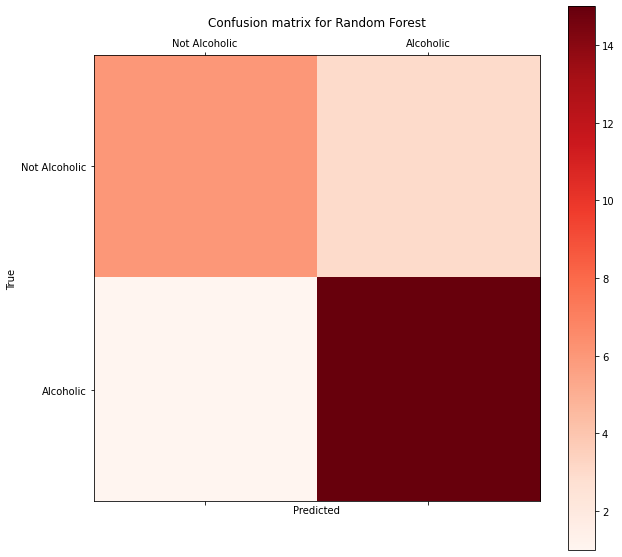

In [36]:
confusion_matrices = [("Random Forest", confusion_matrix(y_test,y_pred))]
draw_confusion_matrices(confusion_matrices)

In [ ]:
# For all features
rf_best = clf_gridCV.best_estimator_
print_grid_search_metrics(clf_gridCV)


Best score: 0.7738721804511279

Best parameters set:

criterion:entropy

max_depth:5

max_features:auto

min_samples_split:8

n_estimators:100

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=440,
                       verbose=0, warm_start=False)

In [ ]:
rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)

In [ ]:
df_importance_features = pd.DataFrame(rf_best.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
df_importance_features.head(20)

	importance

235	0.014198

1570	0.012267

1637	0.012248

547	0.011885

1050	0.009264

1555	0.008397

551	0.008328

897	0.008223

1200	0.008156

1249	0.007354

1223	0.007291

218	0.007129

1329	0.007061

1546	0.007013

1216	0.006696

584	0.006581

1331	0.006431

925	0.006241

1467	0.006211

561	0.006196

importance

1170	0.010216

1752	0.008834

1200	0.008252

1637	0.007758

943	  0.007506

475	  0.007002

1614	0.006604

235	  0.006530

546	  0.006334

1636	0.005944

In [35]:
# calculate accuracy, precision and recall, [[tn,fp],[]]
def cal_evaluation(classifier, cm):
  tn = cm[0][0]
  fp = cm[0][1]
  fn = cm[1][0]
  tp = cm[1][1]
  accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
  precision = tp / (tp + fp + 0.0)
  recall = tp / (tp + fn + 0.0)
  print(classifier)
  print("Accuracy is: " + str(accuracy))
  print("precision is: " + str(precision))
  print("recall is: " + str(recall))
  print('Specificity is', tn/(fp+tn))
  

# Pring out confusion matrix
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not Alcoholic','Alcoholic']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for ' + classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.68
precision is: 0.75
recall is: 0.75
Specificity is 0.5555555555555556


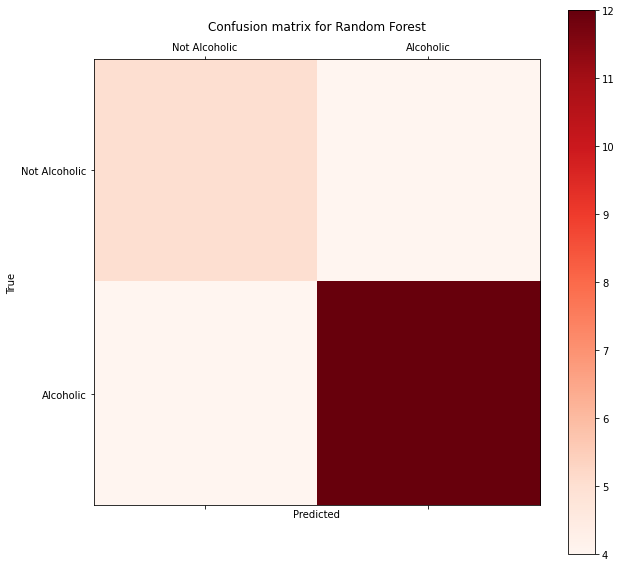

In [ ]:
confusion_matrices = [("Random Forest", confusion_matrix(y_test,y_pred))]
draw_confusion_matrices(confusion_matrices)

Random Forest

Accuracy is: 0.7464788732394366

precision is: 0.7413793103448276

recall is: 0.9347826086956522

Specificity is 0.4